In [1]:
import xarray
import pandas

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

In [2]:
import utils.compound as compound
import utils.timePeriod as tp
import utils.sstIndex as sst
from helpers.fileHandler import to_365day_monthly 
import utils.ecIndex as ec
import utils._indexDefinitions as _index

%run helpers/impactPlots.ipynb

# If we plot some impact maps now, do they look plausible?

In [3]:
eventsXr=xarray.load_dataset('results/obsEvents.nc')

In [4]:
prTWarmSeasonXr = xarray.load_dataset('results/observPrTmaxAnoms.nc')

In [5]:
eventsLs = {
    'summer':['eIndex', 'cIndex', 'dmi','samSummer'],
    'winter':['eIndex', 'cIndex', 'dmi','samWinter']
}

# Anoms for indiv indices

In [6]:
%run helpers/impactPlots.ipynb

pos
winter


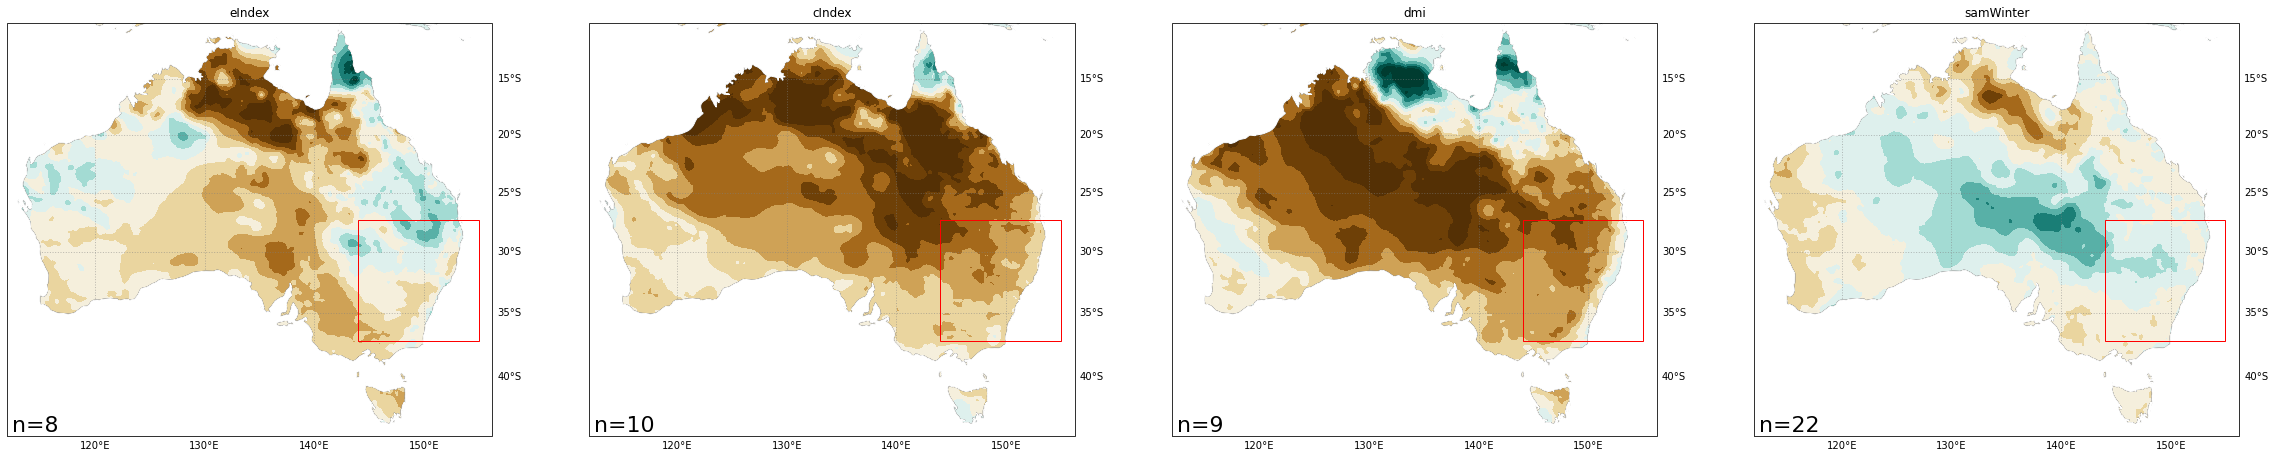

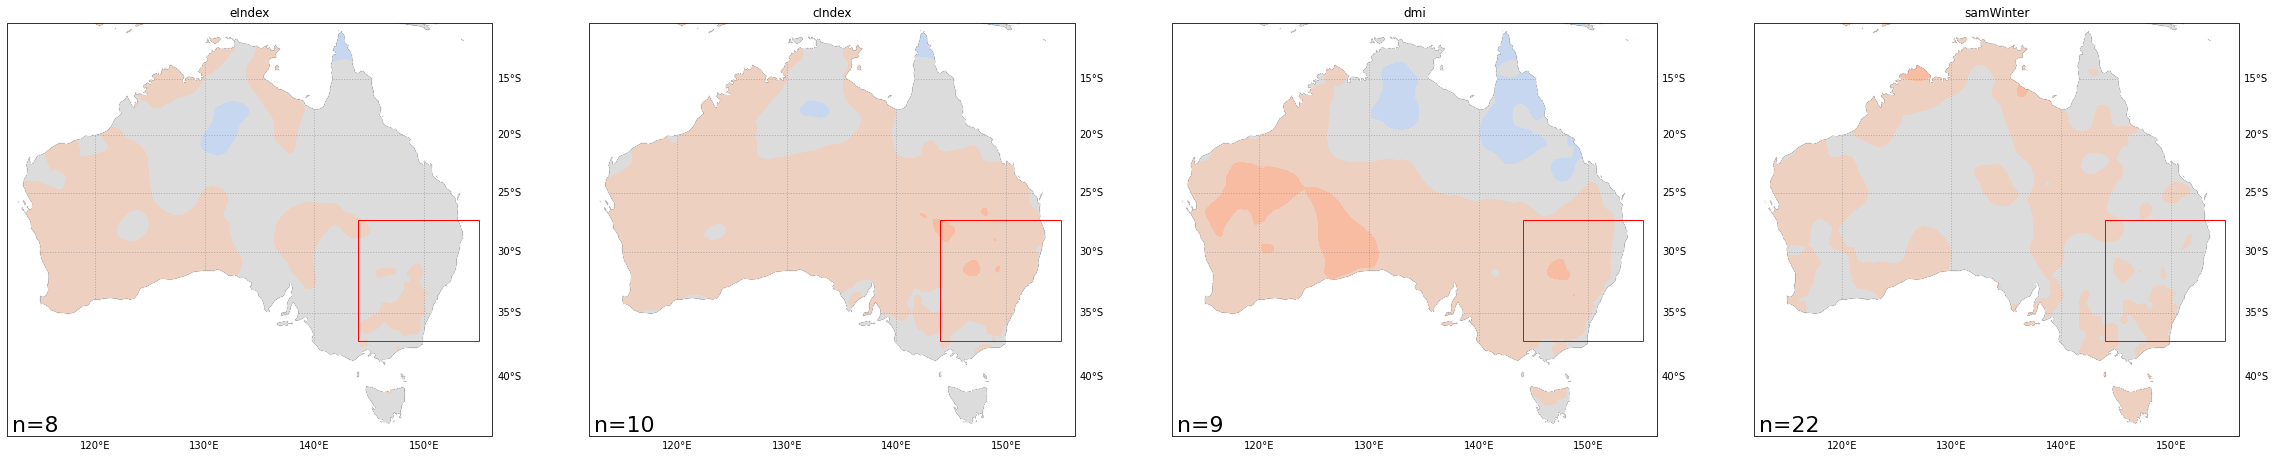

summer


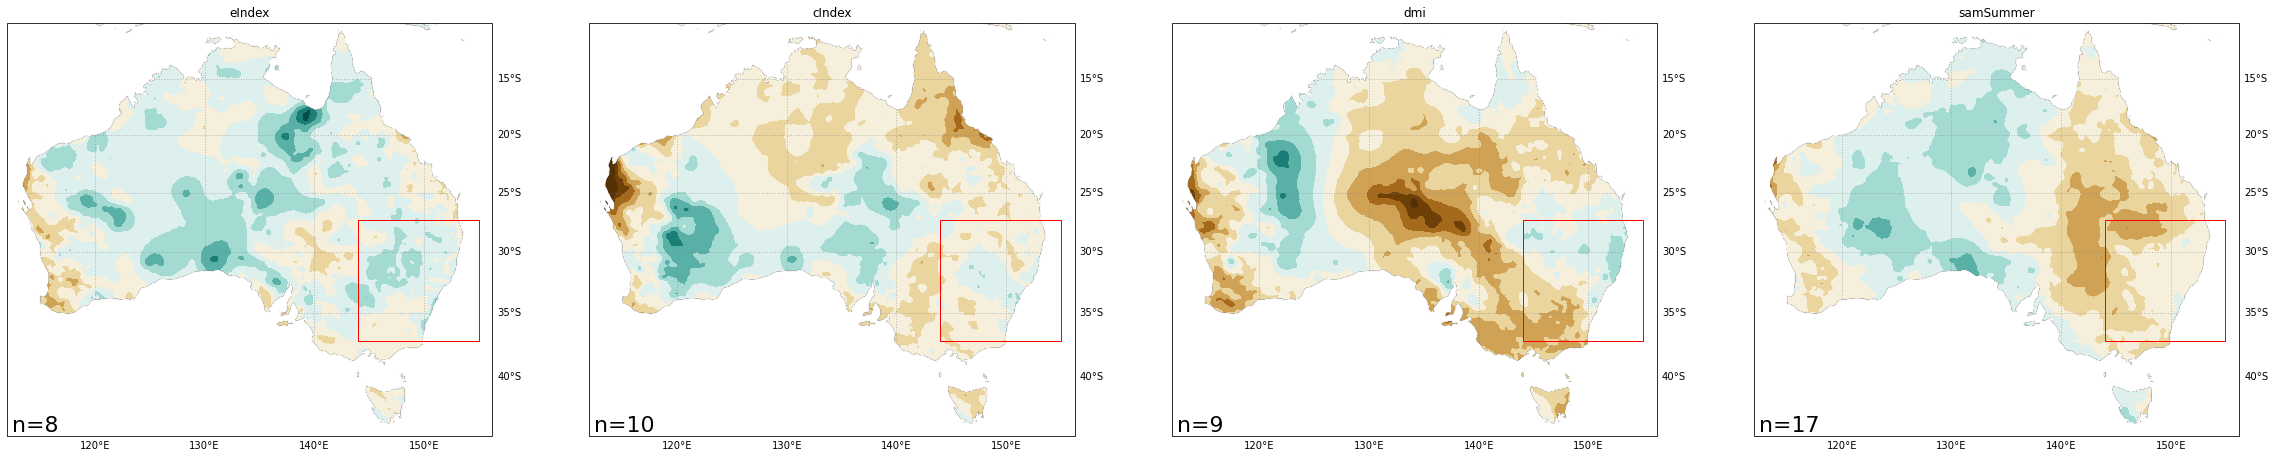

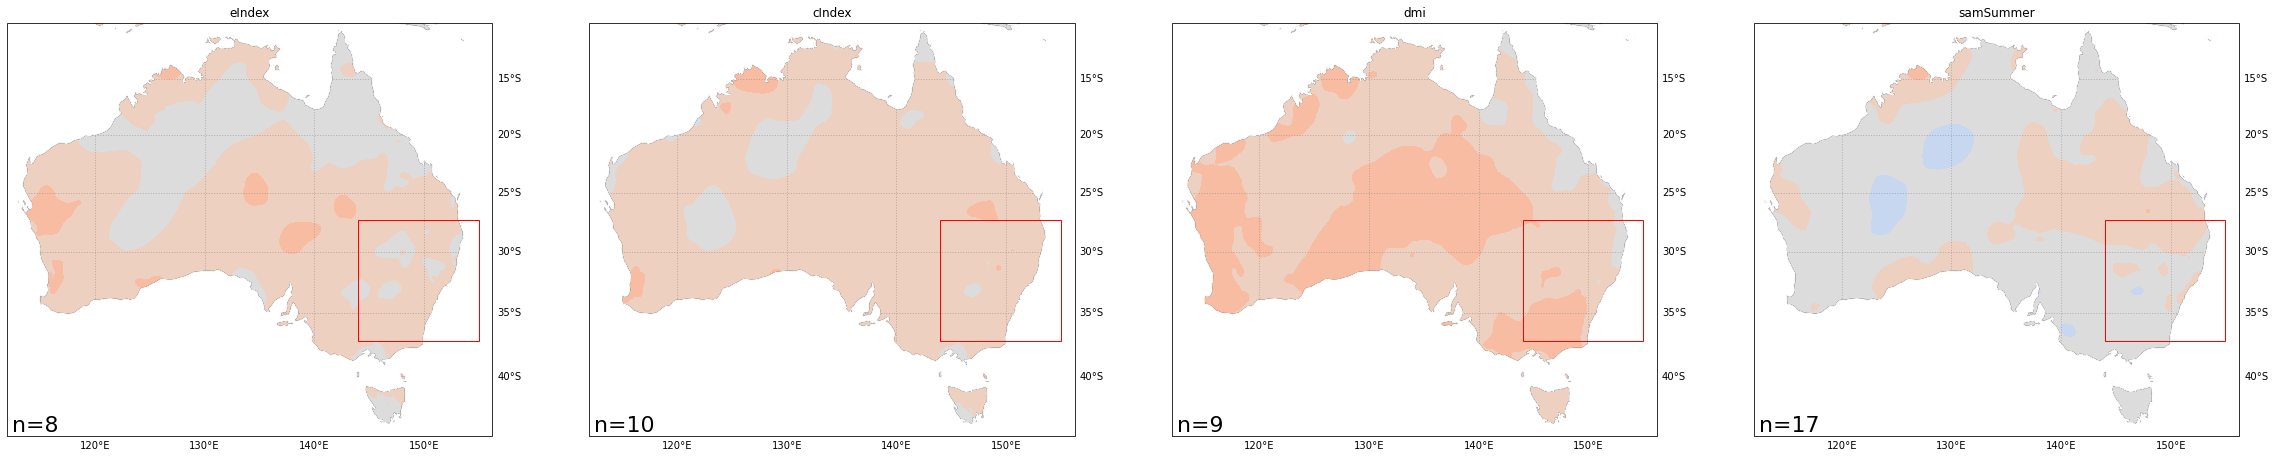

neg
winter


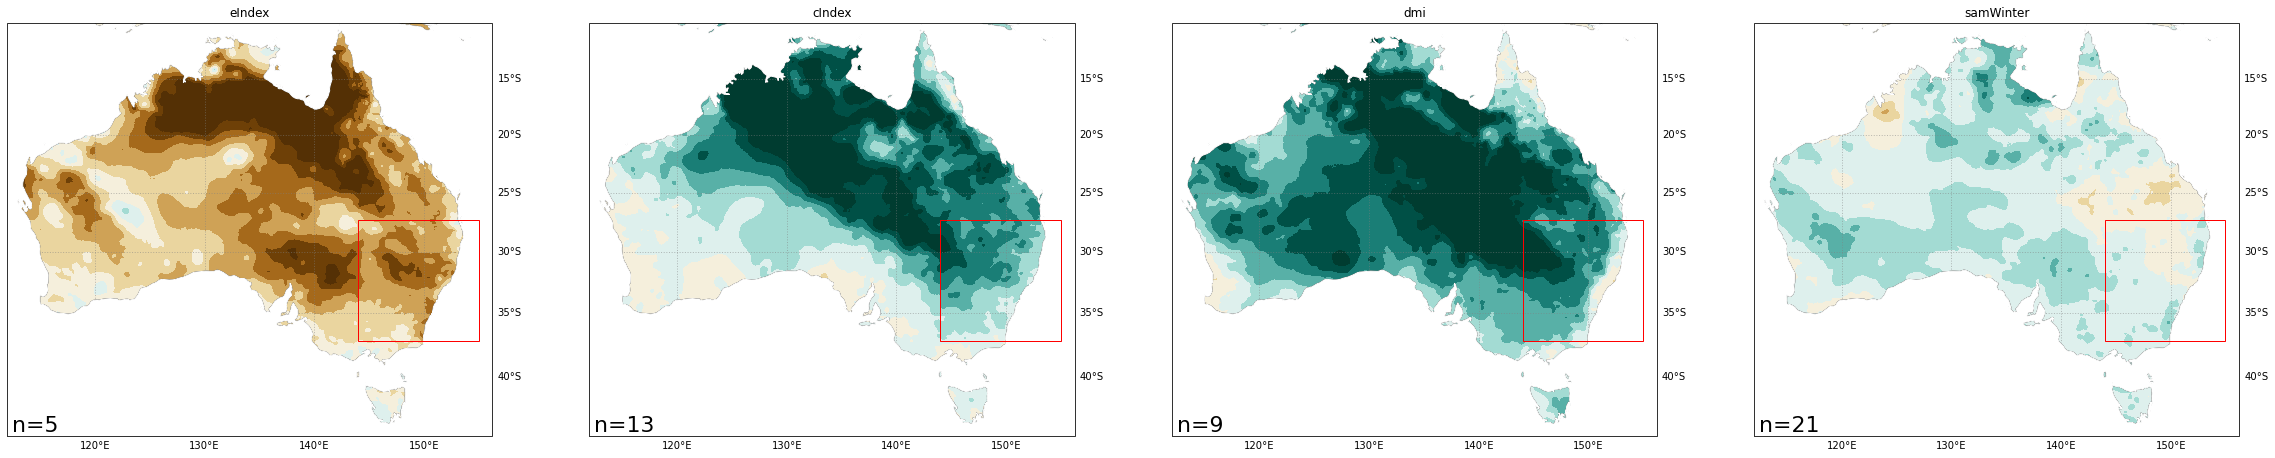

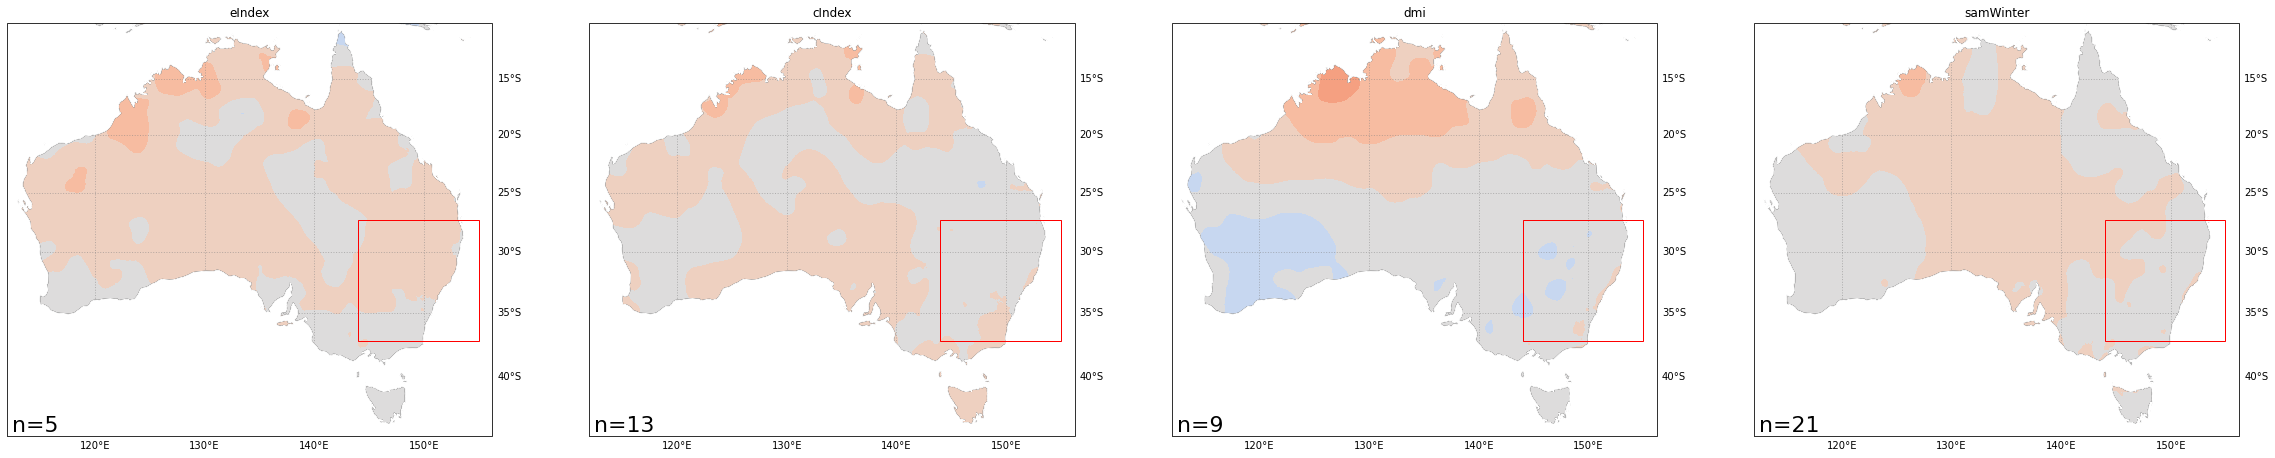

summer


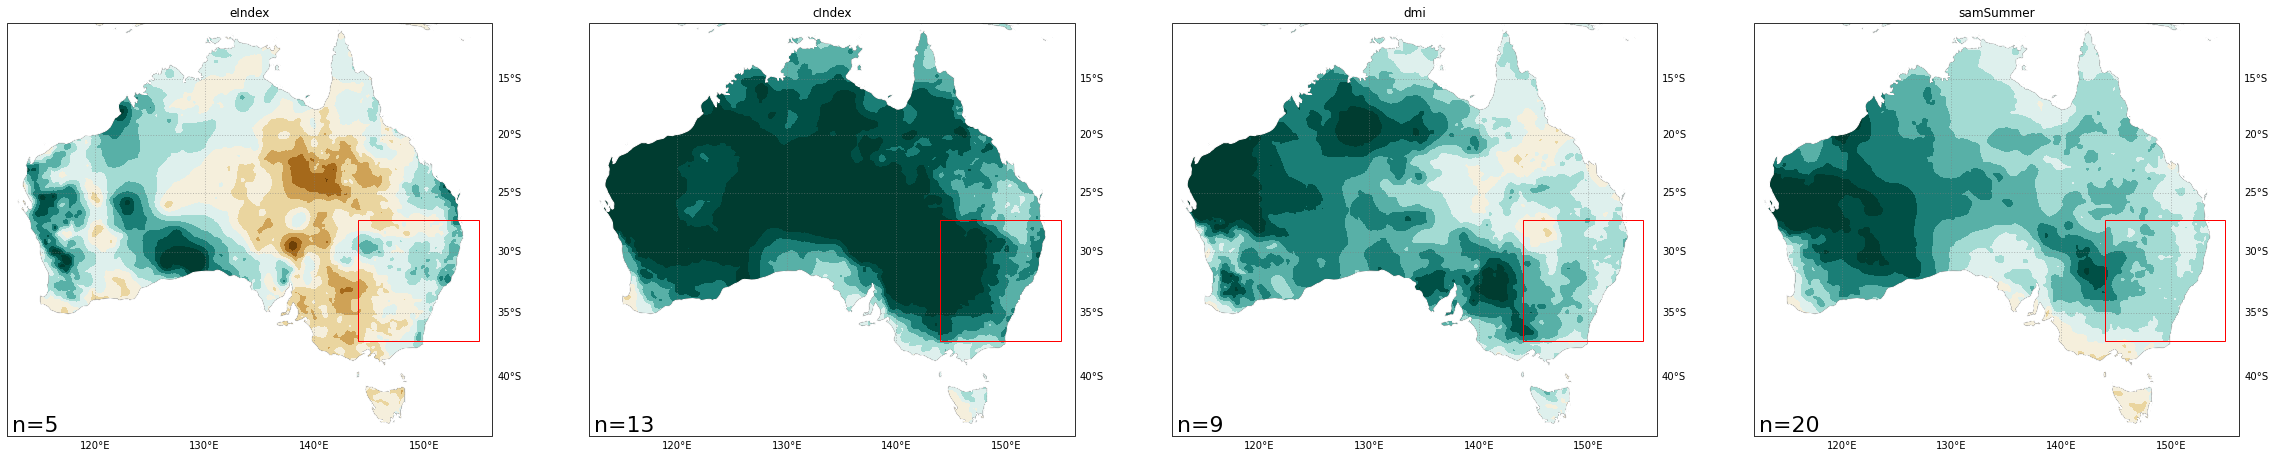

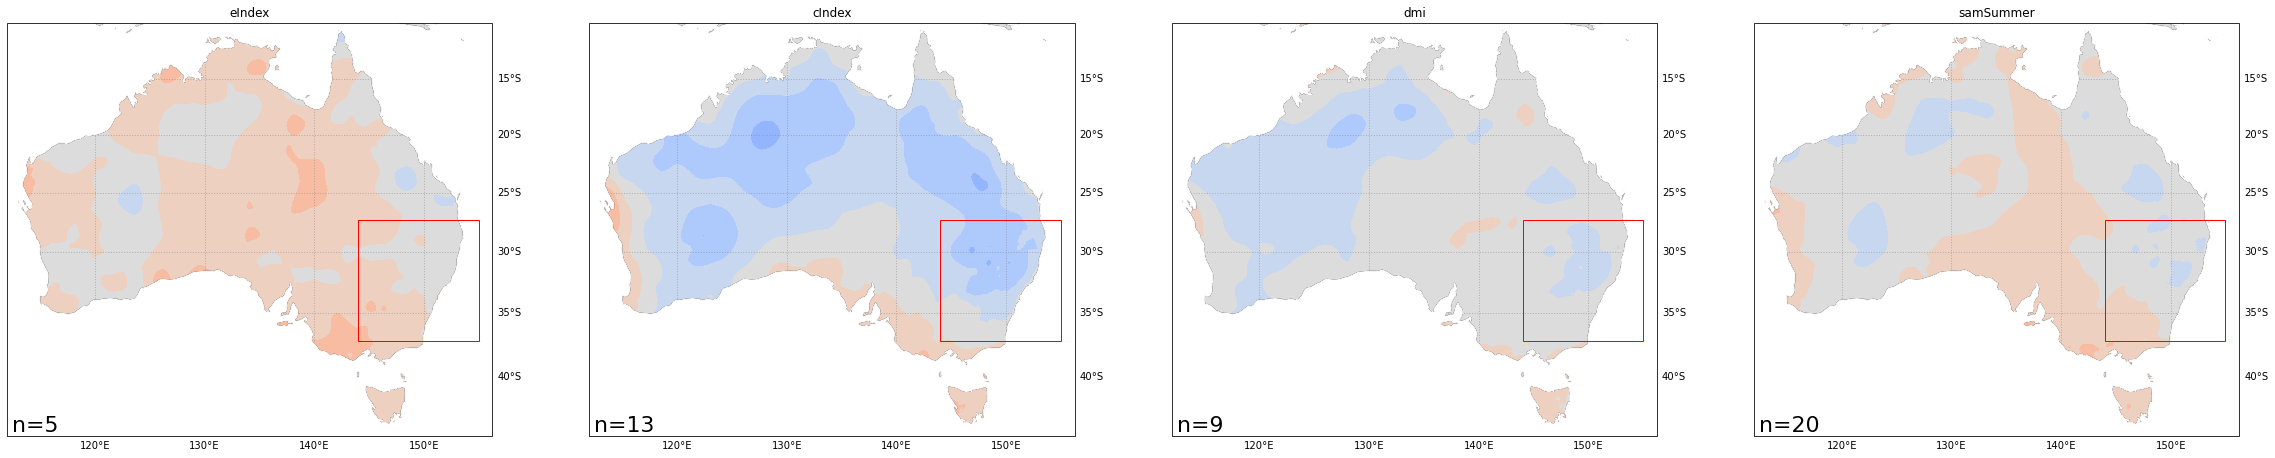

In [7]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (
                prTWarmSeasonXr['prAnom'+iSeason.capitalize()]
                *100
                /prTWarmSeasonXr['pr'+iSeason.capitalize()]
            ).rename('prPercent'), 
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason],
            showOcean=False, stipling=False
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            eventsXr.sel(fire=iFire, drop=True), 
            eventsLs[iSeason],
            showOcean=False, stipling=False
        )
        plt.show()

# Compound them and see what happens

In [8]:
compoundEventsXr=compound.compound(eventsXr)

nino34DmiSamsummer
nino34DmiSamwinter
nino34EastioSamsummer
nino34EastioSamwinter
ecCombinedDmiSamsummer
ecCombinedDmiSamwinter
ecCombinedEastioSamsummer
ecCombinedEastioSamwinter
eIndexDmiSamsummer
eIndexDmiSamwinter
eIndexEastioSamsummer
eIndexEastioSamwinter
cIndexDmiSamsummer
cIndexDmiSamwinter
cIndexEastioSamsummer
cIndexEastioSamwinter


In [9]:
indexSet='ecCombinedDmiSam'

In [10]:
compoundEventsLs=[*compoundEventsXr.indeces,*compoundEventsXr.pairs, 'all3']

In [11]:
compoundEventsLs

['enso', 'iod', 'sam', 'enso+iod', 'enso+sam', 'iod+sam', 'all3']

In [12]:
#enso+iod compound years, realWorld


pos
winter


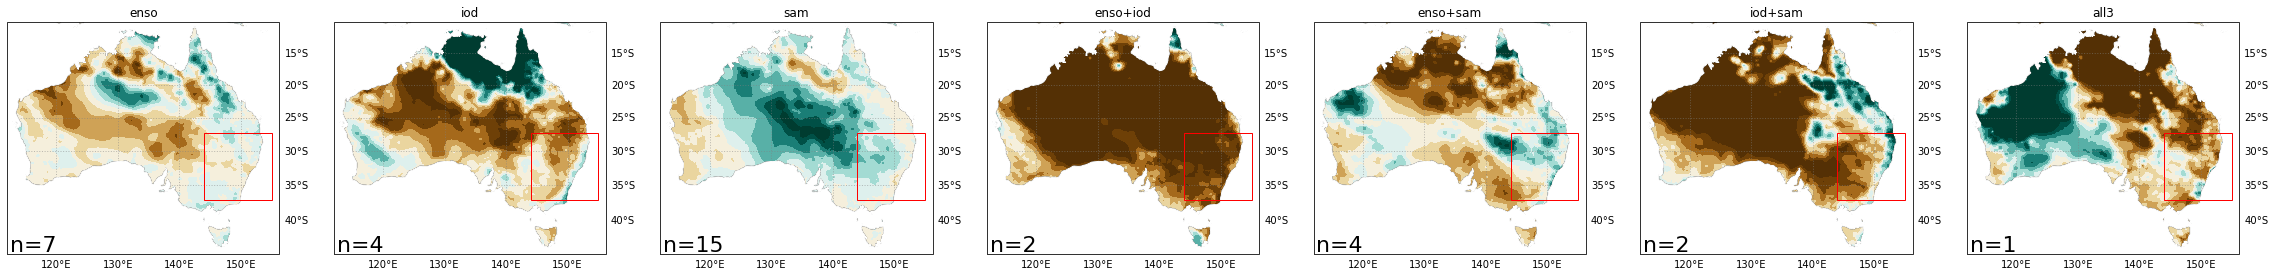

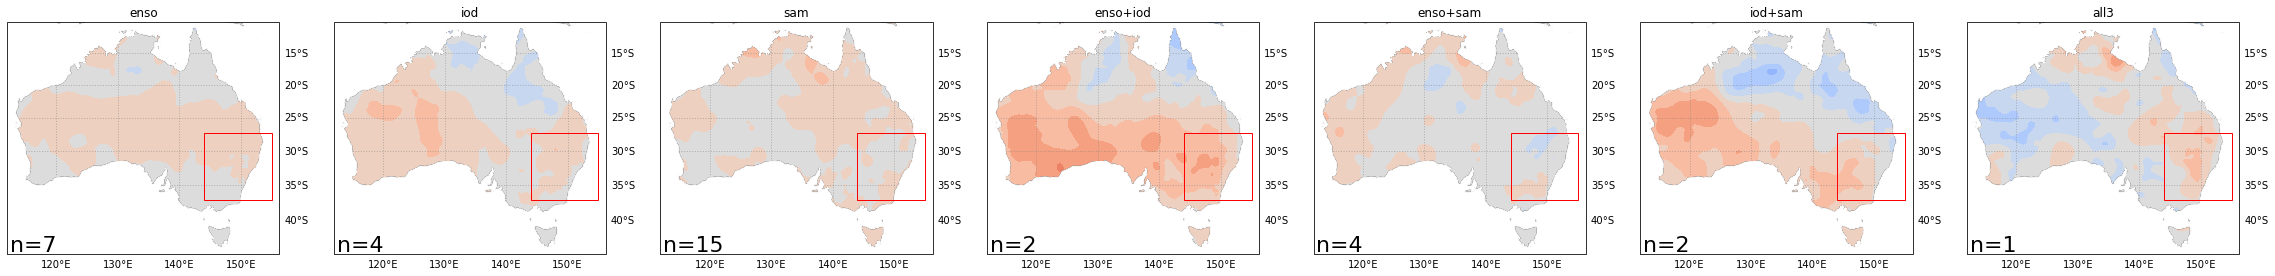

summer


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


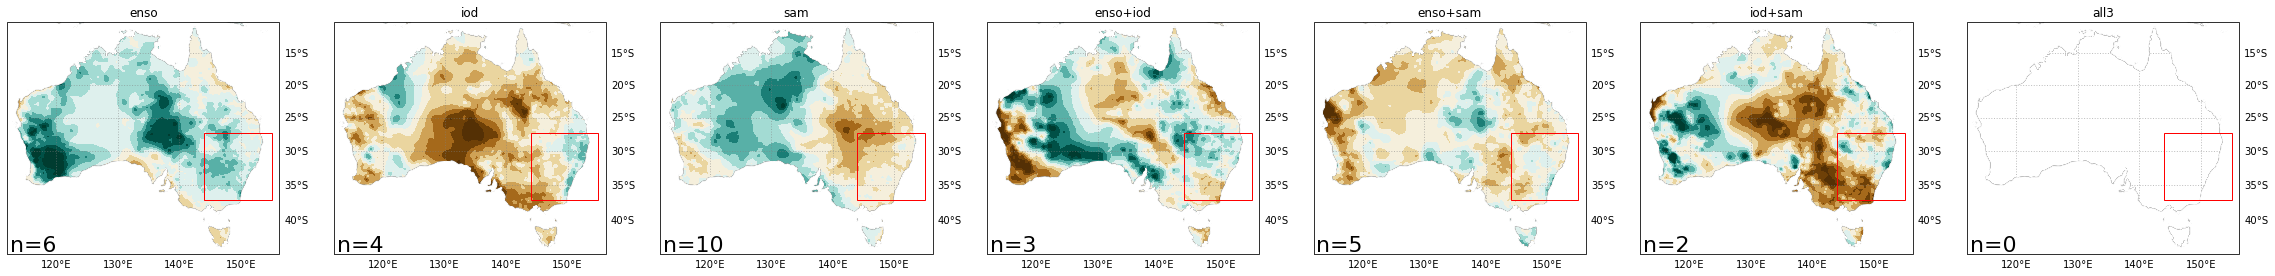

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


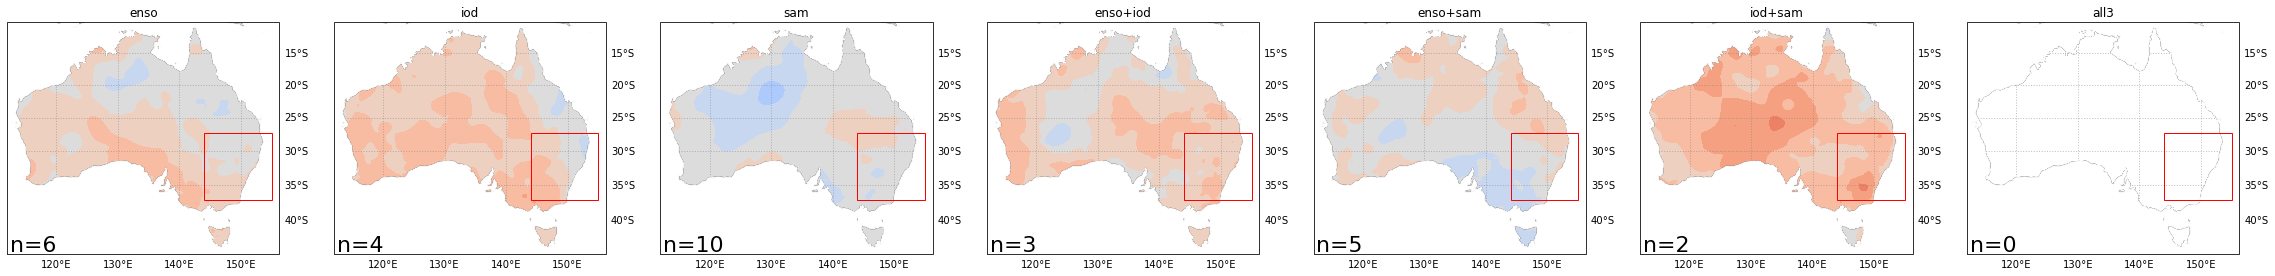

neg
winter


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


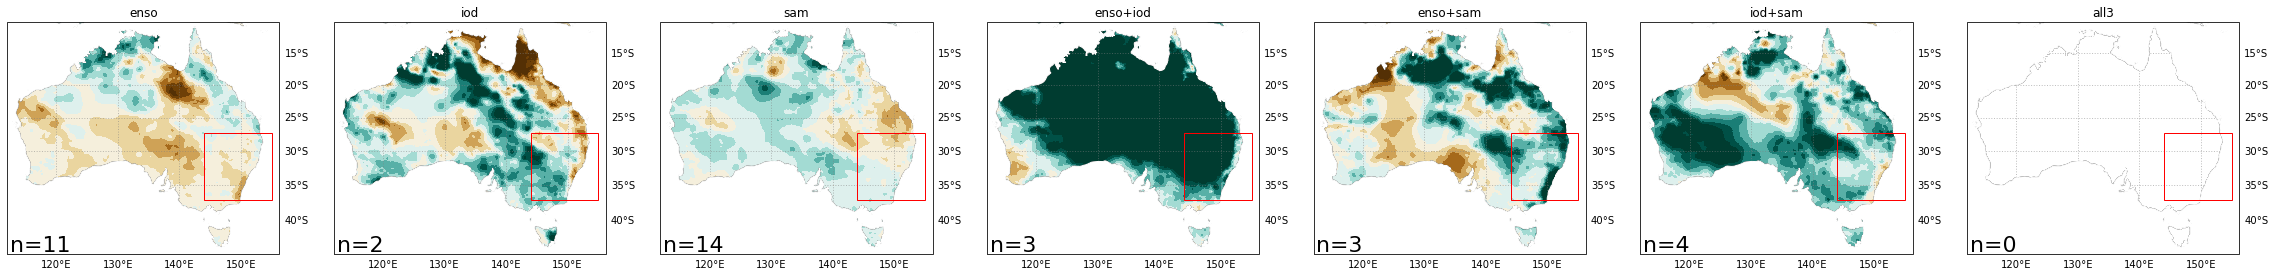

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-21.04/lib/python3.8/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


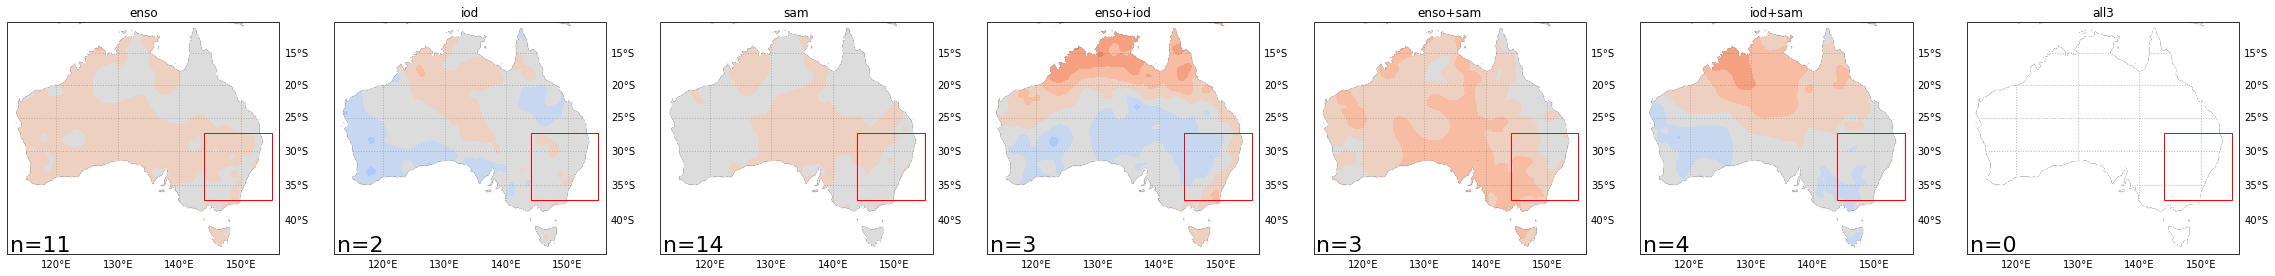

summer


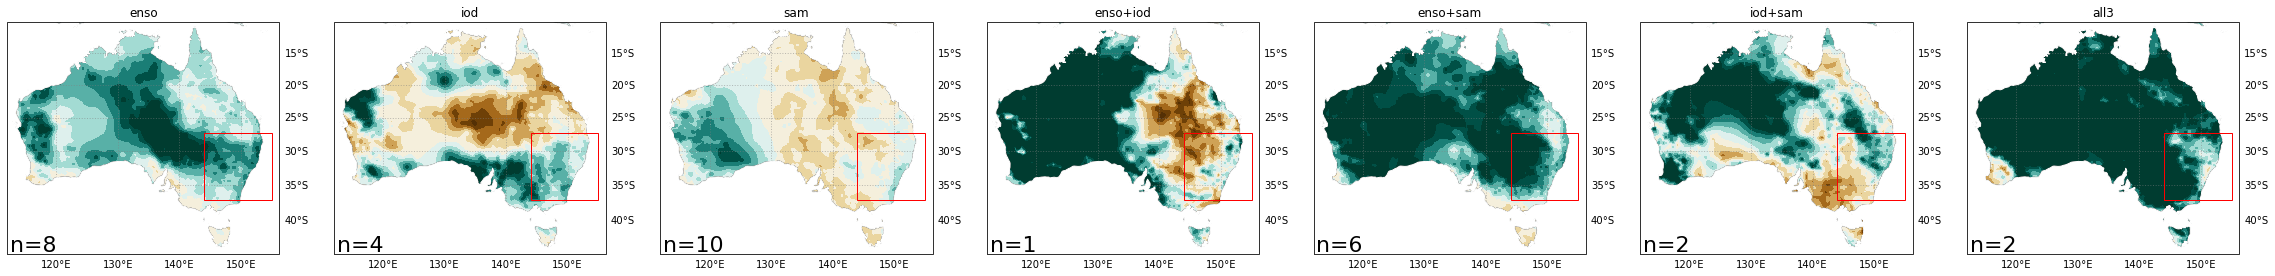

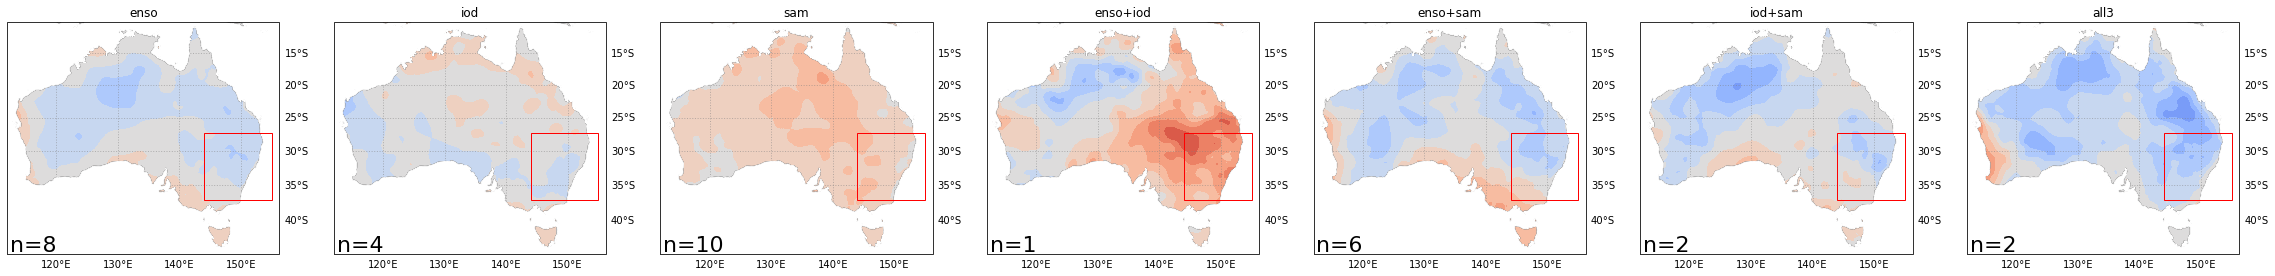

In [13]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (prTWarmSeasonXr['prAnom'+iSeason.capitalize()]*100/prTWarmSeasonXr['pr'+iSeason.capitalize()]).rename('prPercent'), 
            compoundEventsXr[indexSet+iSeason].sel(fire=iFire, drop=True).to_dataset('compound'), 
            compoundEventsLs,
            showOcean=False, stipling=False
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            compoundEventsXr[indexSet+iSeason].sel(fire=iFire, drop=True).to_dataset('compound'), 
            compoundEventsLs,
            showOcean=False, stipling=False
        )
        plt.show()

# And comparison between the three enso indices

In [14]:
ensoIodEventsXr=compoundEventsXr.sel(compound='enso+iod', drop=True)

In [15]:
ensoIodEventsLs=list(ensoIodEventsXr.data_vars)

In [16]:
ensoIodEventsLs

['nino34DmiSamsummer',
 'nino34DmiSamwinter',
 'nino34EastioSamsummer',
 'nino34EastioSamwinter',
 'ecCombinedDmiSamsummer',
 'ecCombinedDmiSamwinter',
 'ecCombinedEastioSamsummer',
 'ecCombinedEastioSamwinter',
 'eIndexDmiSamsummer',
 'eIndexDmiSamwinter',
 'eIndexEastioSamsummer',
 'eIndexEastioSamwinter',
 'cIndexDmiSamsummer',
 'cIndexDmiSamwinter',
 'cIndexEastioSamsummer',
 'cIndexEastioSamwinter']

In [17]:
ensoIodEventLs=[
    'ecCombinedDmiSam',
    'cIndexDmiSam',
    'eIndexDmiSam',
    'nino34DmiSam'
]


pos
winter


ValueError: 'model' not found in array dimensions ('lat', 'lon')

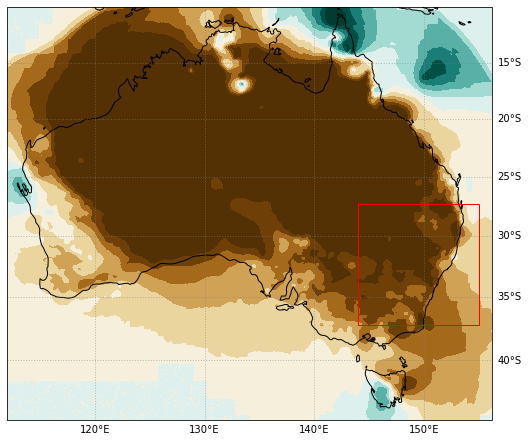

In [18]:
for iFire in ['pos','neg']:
    print(iFire)
    for iSeason in ['winter','summer']:
        print(iSeason)

        indexPlotter(
            (prTWarmSeasonXr['prAnom'+iSeason.capitalize()]*100/prTWarmSeasonXr['pr'+iSeason.capitalize()]).rename('prPercent'), 
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs]
        )
        plt.show()
        indexPlotter(
            prTWarmSeasonXr['tsAnom'+iSeason.capitalize()], 
            ensoIodEventsXr[[start+iSeason for start in ensoIodEventLs]].sel(fire=iFire, drop=True), 
            [start+iSeason for start in ensoIodEventLs]
        )
        plt.show()